In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os,sys
import matplotlib.pyplot as plt
import numpy as np
import helper



Error: Jupyter cannot be started. Error attempting to locate jupyter: 

In [8]:
from dataloader import *

# use same transform for train/val for this example

trans = transforms.Compose([
   transforms.CenterCrop((200,300)), transforms.ToTensor(),
])

data_train='/users/eleves-b/2017/mohamed.traore/MAP583/dataset/train'
data_valid='/users/eleves-b/2017/mohamed.traore/MAP583/dataset/valid'
train_set = Pick_images(data_train,transform = trans)
val_set = Pick_images(data_valid,transform = trans)

image_datasets = {
    'train': train_set, 'val': val_set
}

batch_size = 5

dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)
}

dataset_sizes = {
    x: len(image_datasets[x]) for x in image_datasets.keys()
}

dataset_sizes




{'train': 24, 'val': 24}

In [11]:
import torch
import torch.nn as nn
import pytorch_unet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [12]:
for images, masks in dataloaders["train"]:
                images = images.to(device)
                masks = masks.to(device)  
                break;           


In [15]:
masks

tensor([[[[0.0667, 0.0902, 0.1176,  ..., 0.5765, 0.5686, 0.5490],
          [0.0667, 0.0824, 0.1176,  ..., 0.5647, 0.5647, 0.5529],
          [0.0824, 0.1020, 0.1098,  ..., 0.5647, 0.5647, 0.5529],
          ...,
          [0.0784, 0.0784, 0.0745,  ..., 0.0784, 0.0745, 0.0706],
          [0.0745, 0.0745, 0.0745,  ..., 0.0784, 0.0745, 0.0706],
          [0.0824, 0.0863, 0.0902,  ..., 0.0706, 0.0706, 0.0667]],

         [[0.0824, 0.1059, 0.1333,  ..., 0.6627, 0.6549, 0.6353],
          [0.0784, 0.0980, 0.1333,  ..., 0.6510, 0.6510, 0.6392],
          [0.0863, 0.1059, 0.1294,  ..., 0.6510, 0.6510, 0.6392],
          ...,
          [0.0941, 0.0941, 0.0902,  ..., 0.1098, 0.1059, 0.1020],
          [0.0902, 0.0902, 0.0902,  ..., 0.1020, 0.1020, 0.0980],
          [0.0863, 0.0902, 0.0941,  ..., 0.1020, 0.1020, 0.0980]],

         [[0.0784, 0.1020, 0.1412,  ..., 0.7059, 0.6980, 0.6784],
          [0.0824, 0.0941, 0.1333,  ..., 0.6941, 0.6941, 0.6824],
          [0.0941, 0.1098, 0.1255,  ..., 0

In [3]:
# from torch import summary

model = pytorch_unet.UNet()
model = model.to(device)
# print(model)
# summary(model, input_size=(3, 224, 224))

In [4]:
from collections import defaultdict
import torch.nn.functional as F
# from loss import dice_loss
import torch.nn as nn

criterion = nn.MSELoss() 

def train_model(model, optimizer, scheduler, criterion ,num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                    
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            # metrics = defaultdict(float)
            epoch_samples = 0
            
            for images, masks in dataloaders[phase]:
                images = images.to(device)
                masks = masks.to(device)             

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(masks)
                    loss=criterion(outputs,images)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples = images.size(0)

            epoch_loss = loss / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [11]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=1e-4) ### Decay

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=25, gamma=0.1)

model = train_model(model, optimizer_ft, exp_lr_scheduler,criterion, num_epochs=1)

Epoch 0/0
----------
LR 0.0001


(3, 6, 192, 192)


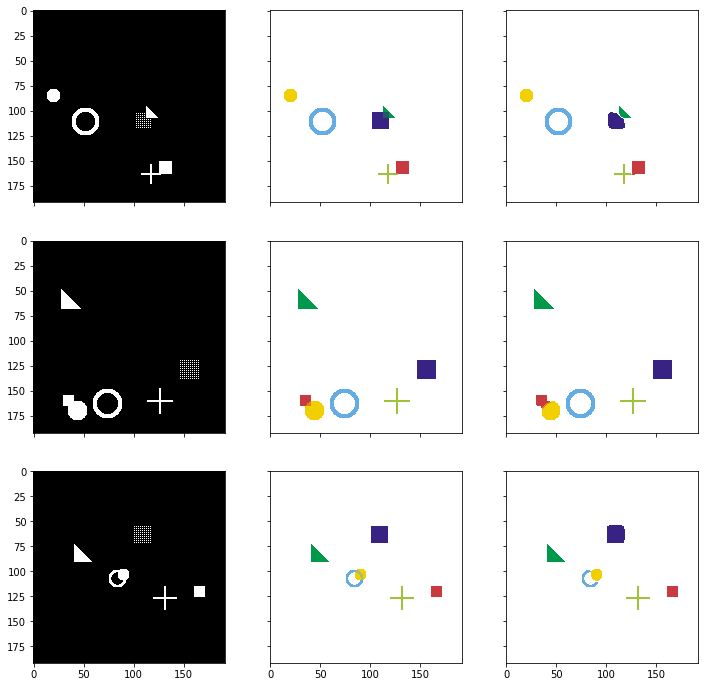

In [8]:
# prediction

import math

model.eval()   # Set model to evaluate mode

test_dataset = SimDataset(3, transform = trans)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, num_workers=0)
        
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)

pred = model(inputs)

pred = pred.data.cpu().numpy()
print(pred.shape)

